# DATASCI W261: Machine Learning at Scale

## HW10

- **Juanjo Carin**
- [juanjose.carin@ischool.berkeley.edu](mailto:juanjose.carin@ischol.berkeley.com)
- W261-2
- Week 10
- Submission date: 11/17/2015

> **N.B.: HW10.1 contains different solutions to the question, and HW10.4 includes an analysis of WSSSE as a function of K.**

## Spark initialization

In [1]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = \
   '/HD/spark/'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

#from pyspark import SparkConf, SparkContext
#conf = SparkConf().setMaster("local").setAppName("My App")
#sc.stop()
#sc = SparkContext(conf = conf)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.2
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:04:42)
SparkContext available as sc, HiveContext available as sqlContext.


# HW 10.0: Short answer questions

* **What is Apache Spark and how is it different to Apache Hadoop?**

**Apache Spark** is a cluster computing platform (i.e., an engine for large-scale data processing). It is compatible with **Apache Hadoop**, but it performs in-memory computing (so it outperforms disk-based engines like Hadoop), and hence it is much faster (100x in memory, 10x on disk). It also requires 2 to 5 times less code, allows lazy evaluation, includes many more operations than just map and reduce, etc.

* **Fill in the blanks:**

Spark API consists of interfaces to develop applications based on it in Java**, Scala, and Python (and now also in R)** languages.

Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or **YARN** in a distributed manner.

* **What is an RDD and show a fun example of creating one and bringing the first element back to the driver program.**

An **RDD** (Resilient Distributed Dataset) is an immutable distributed collection of objects, created by loading an external dataset or by distributing a collection of objects in the driver program.

They are resilient because they can be recomputed any time (e.g., when a machine holding it fails), distributed because the collection of objects they contain can be located in multiple machines' memory, and immutable because transformations do not change them but create new RDDs.

In [2]:
## Create 10 RDDs, ranging from 1 to 10, 11 to 20, and so on
## and print 1st element of each
for i in range(10):
    nums = sc.parallelize(range(1+i*10, 10+i*10))
    print nums.first()

## Create a RDD with the letters of the alphabet and bring the first one
import string
sc.parallelize(string.ascii_lowercase).first()

1
11
21
31
41
51
61
71
81
91


'a'

* **What is lazy evaluation and give an intuitive example of lazy evaluation and comment on the massive computational savings to be had from lazy evaluation.**

**Lazy evaluation** means that expressions are not evaluated when they are bound to variables, but their evaluation is deferred until their results are needed by other computations. In Spark, *transformations* on RDDs are lazily evaluated, so they are not executed until Spark performs an *action*.

So when we call, for example,

    sc.textFile(file).filter(condition).map(function1).reduce(function2)
    
(i.e., apply a MapReduce job only on records of a file that meet a certain condition, the 3 transformations above (not only only the `filter` and `map` but also the creation of the RDD with `textFile`) are note executed until the call to the action `reduce`. Then, each record of the file is loaded into memory, the condition is checked, and only if it's met the `function1` is applied and the result is aggregated according to `function2`.

This can reduce dramatically the number of passes Spark has to take over the data by grouping operations together (and hence there is no need to chain the operations together, as it's done in the pseudocode above).

# HW 10.1

**In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document as a the example document to run an experiment.  Report the following: provide a sorted list of tokens in decreasing order of frequency of occurence.**

I tried 3 different approaches, that (just for fun) I tested with a longer document: **THE COMPLETE WORKS OF WILLIAM SHAKESPEARE** (excluding stop words; the file also contains some copyright information and other additional text).

In [3]:
## Download the complete works of William Shakespeare
    ## I tried to load the file directly from the web but 
    ## "An error occurred while calling o3445.partitions"
!wget -nc http://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

## Summary of the file
!echo "Number of lines:                                          "\
    $(wc -l < t8.shakespeare.txt)
!echo "Number of words:                                          "\
    $(wc -w < t8.shakespeare.txt)
!echo "Number of unique words:                                   "\
    $(tr -s '[[:space:]]' '\n' < t8.shakespeare.txt | sort | uniq | wc -l)
!echo "Number of unique words (lowered and without punctuation): "\
    $(tr -s '[[:punct:][:space:]]' '\n' < t8.shakespeare.txt | sed 's/.*/\L&/'\
      | sort | uniq | wc -l)

## Create list of stop words
from nltk.corpus import stopwords
stop_words = [x.encode('utf-8') for x in stopwords.words('english')]

## Create RDD
lines = sc.textFile('t8.shakespeare.txt').persist()

--2015-11-17 16:26:29--  http://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
Resolving ocw.mit.edu (ocw.mit.edu)... 184.51.102.67, 184.51.102.25
Connecting to ocw.mit.edu (ocw.mit.edu)|184.51.102.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5458199 (5.2M) [text/plain]
Saving to: ‘t8.shakespeare.txt’

100%[======================================>] 5,458,199   7.30MB/s   in 0.7s   

2015-11-17 16:26:30 (7.30 MB/s) - ‘t8.shakespeare.txt’ saved [5458199/5458199]

Number of lines:                                           124456
Number of words:                                           901325
Number of unique words:                                    66525
Number of unique words (lowered and without punctuation):  23881


In [4]:
##################
## 1st approach ##
##################
def WordCount_1(rdd, stop=[], lower=False, n=None):
    '''Count words in rdd (a Spark RDD)
    Optional: excluding words in stop (a list)
    Optional: lowering words (boolean)
    Optional: report only 'n' most frequent words (integer)'''
    ## Function for 1st transformation (flatMap)
    def emitWordCounts(line):
        ## Somehow equivalent to lambda x: x.split()
        import string
        if lower == False:
            return line.encode('utf-8').\
                translate(string.maketrans("",""), string.punctuation).\
                split()
                ## Translate is reported to be the fastest method of getting 
                    ## rid of punctuation
        else:
            ## If lower specified as True, also convert to lowercase
            return line.encode('utf-8').\
                translate(string.maketrans("",""), string.punctuation).\
                lower().split()
    
    counts = lines.\
        flatMap(emitWordCounts).\
        filter(lambda x: x not in stop).\
        countByValue()
        ## Split into words using emitWordCounts
        ## Omit stop words
        ## Count occurrences
    import operator
    ## Convert the dictionary to list (and sort it by value)
    sorted_counts = sorted(counts.items(), 
                           key=operator.itemgetter(1), 
                           reverse = True)
    if n:
        return sorted_counts[:n]
    else:
        return sorted_counts

##################
## 2nd approach ##
##################
def WordCount_2(rdd, stop=[], lower=False, n=None):
    '''Count words in rdd (a Spark RDD)
    Optional: excluding words in stop (a list)
    Optional: lowering words (boolean)
    Optional: report only 'n' most frequent words (integer)'''
    ## Function for 1st transformation (flatMap)
    def emitWordCounts(line):
        import string
        wordCounts = []
        for w in line.encode('utf-8').\
            translate(string.maketrans("",""), string.punctuation).split():
            if lower == False:
                wordCounts.append((w,1))
            else:
                wordCounts.append((w.lower(),1))
        return wordCounts

    counts = rdd.\
        flatMap(emitWordCounts).\
        filter(lambda kv: kv[0] not in stop).\
        reduceByKey(lambda a, b: a + b).\
        map(lambda (k,v): (v,k)).\
        sortByKey(False).cache()
        ## Split into words using emitWordCounts
        ## Omit stop words
        ## Aggregate counts by word
        ## Invert keys and values (to sort by counts)
        ## Sort by key (now the count)

    if n:
        return counts.take(n)
    else:
        return counts.collect()

##################
## 3rd approach ##
##################
def WordCount_3(rdd, stop=[], lower=False, n=None):
    '''Count words in rdd (a Spark RDD)
    Optional: excluding words in stop (a list)
    Optional: lowering words (boolean)
    Optional: report only 'n' most frequent words (integer)'''
    ## Function for 1st transformation (flatMap)
        ## Same as in Word_Count2
    def emitWordCounts(line):
        import string
        wordCounts = []
        for w in line.encode('utf-8').\
            translate(string.maketrans("",""), string.punctuation).split():            
            if lower == False:
                wordCounts.append((w,1))
            else:
                wordCounts.append((w.lower(),1))
        return wordCounts

    counts = rdd.\
        flatMap(emitWordCounts).\
        filter(lambda kv: kv[0] not in stop).\
        reduceByKey(lambda a, b: a + b).cache()
        ## Split into words using emitWordCounts
        ## Omit stop words
        ## Aggregate counts by word
    if n:
        return counts.\
            takeOrdered(n, key=lambda x: -x[1])
            ## Sort by count
    else:
        ## If n is not defined, return all words
        n = counts.count()
        return counts.\
            takeOrdered(n, key=lambda x: -x[1])

In [5]:
print 'Execution time of WordCount_1'
%timeit -n5 WordCount_1(lines, stop_words, True)
print '\nExecution time of WordCount_2'
%timeit -n5 WordCount_2(lines, stop_words, True)
print '\nExecution time of WordCount_3'
%timeit -n5 WordCount_3(lines, stop_words, True)

Execution time of WordCount_1
5 loops, best of 3: 4.87 s per loop

Execution time of WordCount_2
5 loops, best of 3: 5.99 s per loop

Execution time of WordCount_3
5 loops, best of 3: 6.34 s per loop


It seems like the 1st approach gives better results (in terms of computation time; the 3 of them yield same results, the only difference---when n is specified---is that same values may be repeated so each function may report different words in case of tie).

With that method the sorting is done directly by Python, while in the 2 others sorting is done in Spark; that's why I expected those to be better; but maybe the file is not big enought to take full advantage of Spark.

In [6]:
counts1 = WordCount_1(lines, stop_words, True, 10)
counts2 = WordCount_2(lines, stop_words, True, 10)
counts3 = WordCount_3(lines, stop_words, True, 10)
for count1,count2,count3 in zip(counts1,counts2,counts3):
    print count1[0], '\t', count1[1]
    if count2[1] != count1[0] or count2[0] != count1[1]:
        print count2[1], '\t', count2[0]
    if count3[0] != count1[0] or count3[1] != count1[1]:
        print count3[0], '\t', count3[1]

thou 	5485
thy 	4032
shall 	3591
thee 	3178
lord 	3059
king 	2861
good 	2812
sir 	2754
o 	2608
come 	2507


In [7]:
lines.unpersist()
## Delete file
!rm t8.shakespeare.txt

Let's now use this homework instructions. I collect all words though only the top 20 are printed.

In [8]:
import string
#lines = sc.textFile('./MIDS-MLS-HW-10.txt', 10)
## This line above would partition the file in 10 parts
## That is equivalent to the following
!mkdir parts
!split -n 4 MIDS-MLS-HW-10.txt parts/
lines = sc.textFile('./parts/*').persist()

## Call the 3 methods with optional parameters set to default values
counts1 = WordCount_1(lines)
counts2 = WordCount_2(lines)
counts3 = WordCount_3(lines)

for i in range(1,21):
    print '{})  {}     {}{}{}'.format(str(i).rjust(2), 
                                      str(counts1[i-1][1]).rjust(2), 
                                      counts1[i-1][0].ljust(15), 
                                      counts2[i-1][1].ljust(15), 
                                      counts3[i-1][0].ljust(15))
    if not counts1[i-1][1] == counts2[i-1][0] == counts3[i-1][1]:
        print 'Different counts! CHECK!'

!rm -r parts

 1)  44     the            the            the            
 2)  23     and            and            and            
 3)  17     of             of             of             
 4)  17     in             in             in             
 5)  11     HW             a              a              
 6)  11     a              HW             HW             
 7)  10     code           data           data           
 8)  10     data           code           code           
 9)   9     to             to             to             
10)   7     KMeans         with           with           
11)   7     for            KMeans         KMeans         
12)   7     on             on             on             
13)   7     Using          Using          Using          
14)   7     with           is             is             
15)   7     is             for            for            
16)   6     clusters       clusters       clusters       
17)   6     your           your           your           
18)   5     re

As previously mentioned, the order may vary with the method when the number of occurrences is the same: `HW` and `a` appear 11 times, but the former appears before the latter (as 5th and 6th respectively) with the 1st approach and after it with the 2nd and 3rd; something similar happen with `code` and `data`, `KMeans`, `for`, `with`, and `is`, and so on. Anyway, the results are correct with all approaches.

Getting rid of the punctuation transforms `https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0` into `httpswwwdropboxcomsq85t0ytb9apggnhkmeansdatatxtdl0`, but if we do not do so words followed by comma, for instance, are percevied as different than the same word followed by space.

## HW 10.1.1

**Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.**

I've modified the 2nd method but the idea is similar to the 3 of them: since there was already a filter to discard stop words, we just have to modify it to include only words that begin with a lower case letter.

    .filter(lambda kv: kv[0][0] in string.ascii_lowercase)
       
instead of 

    .filter(lambda kv: kv[0] not in stop)

In [9]:
def WordCount_2(rdd):
    '''Count words in rdd (a Spark RDD)'''
    ## Function for 1st transformation (flatMap)
    def emitWordCounts(line):
        import string
        wordCounts = []
        for w in line.encode('utf-8').\
            translate(string.maketrans("",""), string.punctuation).split():
            wordCounts.append((w,1))
        return wordCounts

    counts = rdd.\
        flatMap(emitWordCounts).\
        filter(lambda kv: kv[0][0] in string.ascii_lowercase).\
        reduceByKey(lambda a, b: a + b).\
        map(lambda (k,v): (v,k)).\
        sortByKey(False).cache()
        ## Split into words using emitWordCounts
        ## Only words that begin with lower case letters
        ## Aggregate counts by word
        ## Invert keys and values (to sort by counts)
        ## Sort by key (now the count)
    return counts.collect()

counts2 = WordCount_2(lines)
for i in range(1,21):
    print '{})  {}     {}'.format(str(i).rjust(2), 
                              str(counts2[i-1][0]).ljust(2), 
                              str(counts2[i-1][1]).rjust(15))

 1)  44                 the
 2)  23                 and
 3)  17                  of
 4)  17                  in
 5)  11                   a
 6)  10                data
 7)  10                code
 8)  9                   to
 9)  7                 with
10)  7                   on
11)  7                   is
12)  7                  for
13)  6             clusters
14)  6                 your
15)  5                 from
16)  5                 this
17)  5           regression
18)  5           iterations
19)  5                   as
20)  4            following


As expected, `HW`, `KMeans`, and `Using` (previously in positions 5, 10, and 13) have been filtered out.

# HW 10.2: KMeans a la MLLib

**Using the following  MLlib-centric KMeans code snippet:**

    from pyspark.mllib.clustering import KMeans, KMeansModel
    from numpy import array
    from math import sqrt

    # Load and parse the data
    # NOTE  kmeans_data.txt is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
    data = sc.textFile("kmeans_data.txt")
    parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, 2, maxIterations=10,
            runs=10, initializationMode="random")

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("Within Set Sum of Squared Error = " + str(WSSSE))

    # Save and load model
    clusters.save(sc, "myModelPath")
    sameModel = KMeansModel.load(sc, "myModelPath")

**Run this code snippet and list the clusters that your find and compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.**

In [18]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import numpy as np

# Load and parse the data
# NOTE  kmeans_data.txt is available here
# https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")
parsedData = data.\
    map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10, 
                        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

#print clusters.centers
## Returns the following
## [array([ 0.1,  0.1,  0.1]), array([ 9.1,  9.1,  9.1])] 

print('\n Cluster center       Point')
cluster_elements = parsedData.\
    map(lambda x: (clusters.centers[clusters.predict(x)], x)).collect()
for kv in cluster_elements:
    print(kv[0],kv[1])

clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

!rm -r /HD/Dropbox2/Dropbox/W261/HW10/myModelPath

Within Set Sum of Squared Error = 0.692820323028

 Cluster center       Point
(array([ 0.1,  0.1,  0.1]), array([ 0.,  0.,  0.]))
(array([ 0.1,  0.1,  0.1]), array([ 0.1,  0.1,  0.1]))
(array([ 0.1,  0.1,  0.1]), array([ 0.2,  0.2,  0.2]))
(array([ 9.1,  9.1,  9.1]), array([ 9.,  9.,  9.]))
(array([ 9.1,  9.1,  9.1]), array([ 9.1,  9.1,  9.1]))
(array([ 9.1,  9.1,  9.1]), array([ 9.2,  9.2,  9.2]))


The 6 points clearly form 2 clusters of 3 aligned points. So, as expected, the centers of the 2 clusters are those points in the midle, equidistant from the other 2 points.

The WSSSE (Within Set Sum of Squared Errors) can be defined as

$$WSSSE = \sum_{i=1}^K \sum_{x \in S_i} d(\mu_i, x)$$

where $d$ is the Euclidean distance, $K$ is the number of clusters, $S_i$ the i-th cluster, $\mu_i$ its centroid, and $x$ a point of the dataset. So the value in this case is $2 \cdot \left(\sqrt{0.1^2 + 0.1^2 + 0.1^2} + \sqrt{0^2 + 0^2 + 0^2} + \sqrt{0.1^2 + 0.1^2 + 0.1^2}\right) = 2 \cdot 2 \cdot \sqrt{3 \cdot 0.1^2} = 0.4 \cdot \sqrt{3} = 0.6928$.

The WSSSE (or WCSS: Within-Cluster Sum of Squares) is a decreasing function that gives an idea of how "compact" all the clusters are; it is zero if each point in the dataset is its own cluster (i.e., it there are as many clusters as points; $WSSSE(n)=0$). So this parameter may be convenient to select an appropriate number of clusters: of course, having as many clusters as points has no use, so a common practice is to select a value of K for which the graph of $WSSSE(K)$ decreases significantly compared to the previous value ($WSSSE(K-1)$), but not to the posterior value ($WSSSE(K+1)$): that is, we stop when WSSSE begins to decrease more slowly. **I explore this at the end of HW10.4.**

# HW 10.3

**Download the following KMeans notebook:**

**https://www.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb?dl=0**

**Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data. Then run MLlib's Kmean implementation on this data  and report your results as follows:**

* **plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.**
* **in each plot please report the Within Set Sum of Squared Errors for the found clusters. Comment on the progress of this measure as the KMeans algorithms runs for more iterations**

In [19]:
%matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 100
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

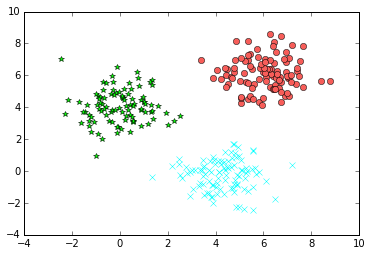

In [20]:
pylab.plot(samples1[:, 0], samples1[:, 1],'x',color = 'cyan')
pylab.plot(samples2[:, 0], samples2[:, 1],'o', color = '#F75D59')
pylab.plot(samples3[:, 0], samples3[:, 1],'*',color = 'Lime')
pylab.show()

In [21]:
import numpy as np
import matplotlib as plt

## Plot centroids and data points for each iteration
    ## Data points with similar color to the closer centroid 
    ## (i.e., to the cluster they've been assigned to)
def plot_cluster(centroids_id):
    def nearest_centroid(line):
        x = np.array([float(f) for f in line.split(',')])
        closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
        return (closest_centroid_idx,(x,1))

    cluster = D.map(nearest_centroid).map(lambda x: (x[0], x[1][0]))
    Colors = plt.cm.Set1(np.linspace(0, 1, K))
    for k in range(K):
        cluster_k = np.array(cluster.lookup(k))
        if k == 0:
            pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', color = 'cyan')
        elif k == 1:
            pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', color = 'Lime')
        else:
            pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', color = '#F75D59')
    pylab.plot(centroids_id[0][1][0], centroids_id[0][1][1],'*',markersize =20,
               color = 'Blue')
    pylab.plot(centroids_id[1][1][0], centroids_id[1][1][1],'*',markersize =20,
               color = 'Green')
    pylab.plot(centroids_id[2][1][0], centroids_id[2][1][1],'*',markersize =20,
               color = 'DarkRed')
    pylab.show()

Let's test this plotting function, that assigns to each point the color of the centroid closer to it (using some random initial centroids).

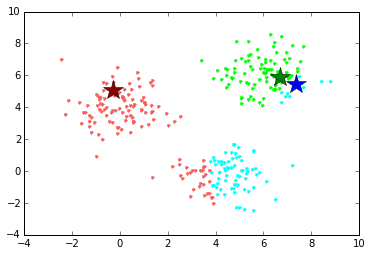

[[ 7.36219885  5.43468731]
 [ 6.71159809  5.87930086]
 [-0.29441832  5.05430725]]


In [23]:
K = 3
D = sc.textFile("./data.csv").cache()
centroids = D.takeSample(False, 3, 13333323453333)
centroids = np.array([[float(x) for x in y.split(',')] for y in centroids])
## Add cluster ID (integer from 0 to K-1)
centroids_id = [(x, centroids[x]) for x in range(centroids.shape[0])]
plot_cluster(centroids_id)
print centroids

Number of iterations:  1
[ 2.11738401  1.91980141]
[ 5.87014469  6.54146342]
[ 6.54435987  4.81455932]
WSSSE = 746.397292912


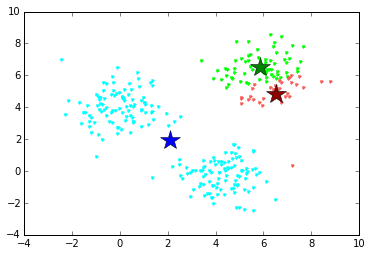

Number of iterations: 10
[-0.00684447  4.06203763]
[ 4.29222758 -0.23805551]
[ 6.04583746  6.11976758]
WSSSE = 375.366658223


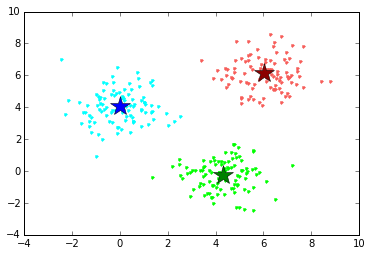

Number of iterations: 20
[ 6.04583746  6.11976758]
[ 4.29222758 -0.23805551]
[-0.00684447  4.06203763]
WSSSE = 375.366658223


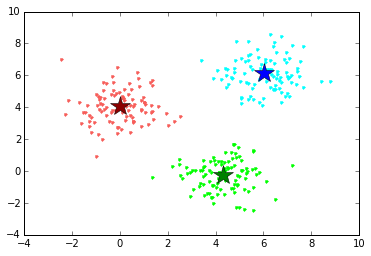

Number of iterations: 100
[ 4.29222758 -0.23805551]
[-0.00684447  4.06203763]
[ 6.04583746  6.11976758]
WSSSE = 375.366658223


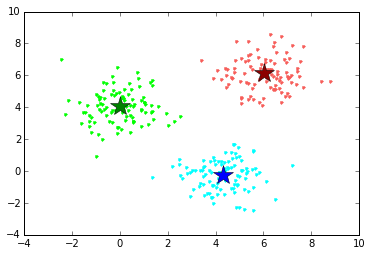

In [24]:
def mllib_KMeans(D, n):

    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    def plot_cluster(centroids_id):

        def nearest_centroid(line):
            x = np.array([float(f) for f in line.split(',')])
            closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
            return (closest_centroid_idx,(x,1))

        cluster = D.map(nearest_centroid).map(lambda x: (x[0], x[1][0]))
        Colors = plt.cm.Set1(np.linspace(0, 1, K))
        for k in range(K):
            cluster_k = np.array(cluster.lookup(k))
            if k == 0:
                pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', 
                           color = 'cyan')
            elif k == 1:
                pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', 
                           color = 'Lime')
            else:
                pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', 
                           color = '#F75D59')
        pylab.plot(centroids_id[0][1][0], centroids_id[0][1][1], '*', 
                   markersize =20, color = 'Blue')
        pylab.plot(centroids_id[1][1][0], centroids_id[1][1][1], '*', 
                   markersize =20, color = 'Green')
        pylab.plot(centroids_id[2][1][0], centroids_id[2][1][1], '*',
                   markersize =20, color = 'DarkRed')
        pylab.show()
    
    from pyspark.mllib.clustering import KMeans, KMeansModel
    from numpy import array
    from math import sqrt

    # Load and parse the data
    data = sc.textFile("data.csv")
    parsedData = data.\
        map(lambda line: array([float(x) for x in line.split(',')]))

    # Build the model (cluster the data)
    clusters = KMeans.train(parsedData, 3, maxIterations=n,
            runs=1, initializationMode="random")
    ##print clusters.centers
    for centroid in clusters.centers:
        print(centroid)

    WSSSE = parsedData.map(lambda point: error(point)).\
        reduce(lambda x, y: x + y)
    print 'WSSSE = {}'.format(str(WSSSE))

    centroids = np.array(clusters.centers)
    centroids_id = [(x, centroids[x]) for x in range(centroids.shape[0])]
    plot_cluster(centroids_id)

#########################

for n in [1, 10, 20, 100]:
    print 'Number of iterations: {}'.format(str(n).rjust(2))
    mllib_KMeans(D, n)

Since `KMeans` from `pyspark.mllib.clustering` does not allow the user to set the centroids (at least in the current version), I've run 1, 10, 20, and 100 iterations, instead of 1, and then another 9, and then another 10, and then another 80 iterations. Anyway, as the centroids converge to the (sub)optimal centroids of the K clusters, so the WSSSE converge to its optimal value for that particular value of K. And the K-Means algorithm converges very fast (for such a small dataset!). Therefore, there is a significant change between the value of the WSSE between 1 and 10 iterations, but the change between 10 and 20 iterations is negligible, and the difference between 20 and 100 iterations is quite small, too.

# HW10.4

**Using the KMeans code (homegrown code) provided repeat the experiments in HW10.3. Comment on any differences between the results in HW10.3 and HW10.4. Explain.**

In [25]:
import numpy as np
import matplotlib as plt

## Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))
    
## REDEFINE PLOT_CLUSTER SO IT'S ADAPTED TO ANY VALUE OF K
    ## USING K COLORS AS MUCH DIFFERENT AS POSSIBLE
## Plot centroids and data points for each iteration
    ## Data points with similar color to the closer centroid 
    ## (i.e., to the cluster they've been assigned to)
def plot_cluster2(D, centroids_id, K):
    cluster = D.map(nearest_centroid).map(lambda x: (x[0], x[1][0]))
    Colors = plt.cm.Set1(np.linspace(0, 1, K))
    for k in range(K):
        cluster_k = np.array(cluster.lookup(k))
        pylab.plot(cluster_k[:, 0], cluster_k[:, 1], '.', color = Colors[k,:], 
                   alpha=0.75)
        pylab.plot(centroids_id[k][1][0], centroids_id[k][1][1], '*', 
                   markersize=15, color = Colors[k,:])
    pylab.show()

See how this new plotting function looks like (I use it later, at the end of this part of the HW).

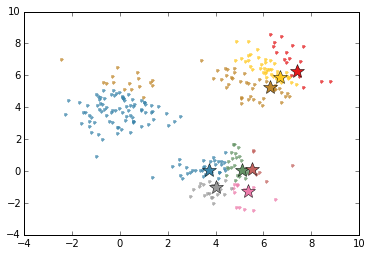

In [26]:
K = 8
## Initialization: choose the K centroids randomly from the dataset
D = sc.textFile("./data.csv").cache()
centroids = D.takeSample(False, K, 12345)
    ## The seed (12345) is optional
    ## I just picked up that one because it selectes 2 of the centroids within 
        ## thesame cluster, making it more "challenging" so the algorithm takes 
        ## a little bit more to converge
centroids = np.array([[float(x) for x in y.split(',')] for y in centroids])
## Add cluster ID (integer from 0 to K-1)
centroids_id = [(x, centroids[x]) for x in range(centroids.shape[0])]
## Plot initial centroids (and clusters)
plot_cluster2(D, centroids_id, K)

`Colors = plt.cm.Set1(np.linspace(0, 1, K))` should be very different from each other, but for K=3 the colors are red, orange, and grey, so I'll stick to `plot_cluster` (if K has to be changed, we just have to change `plot_cluster(centroids_id)` by `plot_cluste2(centroids_id, K)` in the following cells).

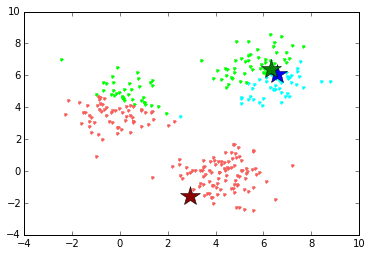

In [32]:
K = 3
## Initialization: choose the K centroids randomly from the dataset
D = sc.textFile("./data.csv").cache()
centroids = D.takeSample(False, K, 123456)
    ## The seed (123456) is optional
    ## I just picked up that one because it selectes 2 of the centroids within 
        ## thesame cluster, making it more "challenging" so the algorithm takes 
        ## a little bit more to converge
centroids = np.array([[float(x) for x in y.split(',')] for y in centroids])
## Add cluster ID (integer from 0 to K-1)
centroids_id = [(x, centroids[x]) for x in range(centroids.shape[0])]
## Plot initial centroids (and clusters)
plot_cluster(centroids_id)


Iteration  1:
-------------
Centroids:
[[ 6.45629272  5.36175467]
 [ 3.36230425  6.04056005]
 [ 2.57239957  1.16769309]]

WSSSE =  728.104869773


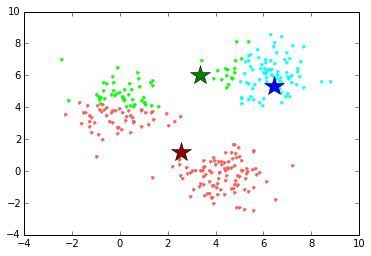


At iteration 5 convergence condition is met
(Centroids coordinates will barely change from this point)
[[ 6.04583746  6.11976758]
 [-0.00684447  4.06203763]
 [ 4.29222758 -0.23805551]]


Iteration 10:
-------------
Centroids:
[[ 6.04583746  6.11976758]
 [-0.00684447  4.06203763]
 [ 4.29222758 -0.23805551]]

WSSSE =  375.366658223


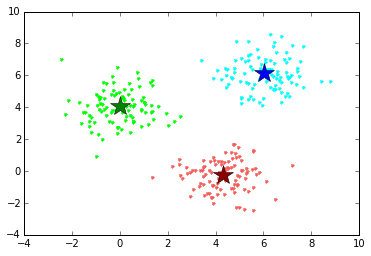


Iteration 20:
-------------
Centroids:
[[ 6.04583746  6.11976758]
 [-0.00684447  4.06203763]
 [ 4.29222758 -0.23805551]]

WSSSE =  375.366658223


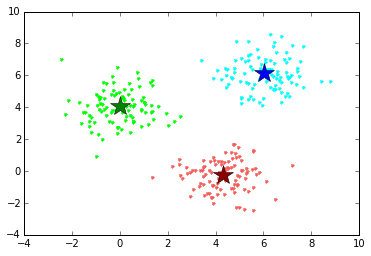


Iteration 100:
-------------
Centroids:
[[ 6.04583746  6.11976758]
 [-0.00684447  4.06203763]
 [ 4.29222758 -0.23805551]]

WSSSE =  375.366658223


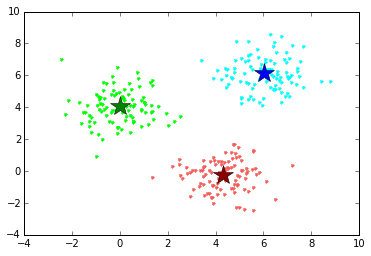

In [33]:
K = 3
## Initialization: choose the K centroids randomly from the dataset
D = sc.textFile("./data.csv").cache()
centroids = D.takeSample(False, K, 123456)
centroids = np.array([[float(x) for x in y.split(',')] for y in centroids])

converge = False

def assign_cluster(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx, x)
def error(point):
    return sqrt(sum([x**2 for x in (point[1] - centroids_id[point[0]][1])]))

for i in range(1, 100+1):  
    ## Return (k, (x,y), n)
        ## k: cluster ID
        ## (x,y): sum of the coordinates of its points)
        ## n: number of points in the cluster = Cluster Size
    res = D.map(nearest_centroid).\
        reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    ## Sort based on clusted ID
    res = sorted(res, key = lambda x : x[0])
    ## Calculate new centroids: (x,y) = (x,y)/n 
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])
    ## Keep cluster ID to match with the color assigned to the cluster
    centroids_id = [(x[0], np.array(x[1][0]/x[1][1])) for x in res]
    ## Normally we would stop when the new centrodis are very similar to the 
        ## previous ones
    if converge == False:
        if np.sum(np.absolute(centroids_new-centroids))<0.01:
            converge = True
            print '\n==========================='
            print 'At iteration {} convergence condition is met'.\
                format(str(i))
            print '(Centroids coordinates will barely change from this point)'
            print centroids
            print '===========================\n'
            #break
    centroids = centroids_new
    ## After 1, 10, 20, and 100 iterations:
    if i==1 or i==10 or i==20 or i==100:
        print '\nIteration {}:'.format(str(i).rjust(2))
        print '-------------'
        print 'Centroids:'
        print centroids
        WSSSE = D.map(assign_cluster).map(error).reduce(lambda a,b: a+b)
        print '\nWSSSE = ', WSSSE
        plot_cluster(centroids_id)

After 10 iterations we have exactly the same centroids and WSSSE with both methods.

The fact that those centroids are not exactly $(6,6)$, $(0,4)$, and $(4,0)$ is not surprising: those were just the means used to generate the 3 normal distributions, and since we generated not many points (100 points in each case), it is normal such a deviation from the actual mean of the random distribution from which the points were extracted.

As mentioned at the end of HW10.3, the only real difference between both approaches is that (due to current limitations in the way `KMeans` from `pyspark.mllib.clustering` is implemented), we cannot set the initial centroids, so the 20 iterations may not start at the same points that the 10 iterations (instead of starting where the 10 iterations stopped), and so on.

## Additional: WSSSE as a function of K and how to select (sub)optimal K
**Let's now demonstrate how K=3 is the optimal number of cluster for this dataset: we'll plot WSSSE from K=1 to K=10, and see how its slope is very steep from K=1 to K=3, and then flatter afterwards.**

**We will also see how the larger the number of clusters, the more it takes the algorithm to converge (though it may vary: `num_iter(K)` is not monotonic).**

In [34]:
def homegrown_Kmeans(D, K, centroids):    
    
    def nearest_centroid(line):
        x = np.array([float(f) for f in line.split(',')])
        closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
        return (closest_centroid_idx,(x,1))
    def assign_cluster(line):
        x = np.array([float(f) for f in line.split(',')])
        closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
        return (closest_centroid_idx, x)
    def error(point):
        return sqrt(sum([x**2 for x in (point[1] - centroids_id[point[0]][1])]))
    
    for i in range(1, 100+1):  
        ## Return (k, (x,y), n)
            ## k: cluster ID
            ## (x,y): sum of the coordinates of its points)
            ## n: number of points in the cluster = Cluster Size
        res = D.map(nearest_centroid).\
            reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
        ## Sort based on clusted ID
        res = sorted(res, key = lambda x : x[0])
        ## Calculate new centroids: (x,y) = (x,y)/n 
        centroids_new = np.array([x[1][0]/x[1][1] for x in res])
        ## Keep cluster ID to match with the color assigned to the cluster
        centroids_id = [(x[0], np.array(x[1][0]/x[1][1])) for x in res]
        if np.sum(np.absolute(centroids_new-centroids))<0.01:
            converge = True
            plot_cluster2(D, centroids_id, K)
            WSSSE = D.map(assign_cluster).map(error).reduce(lambda a,b: a+b)
            print '\n==========================='
            print 'K = {}'.format(str(K))
            print 'At iteration {} convergence condition is met'.\
                format(str(i))
            print 'WSSSE = {}'.format(str(WSSSE))
            print centroids
            print '===========================\n'
            break
        centroids = centroids_new
    return [i, WSSSE]

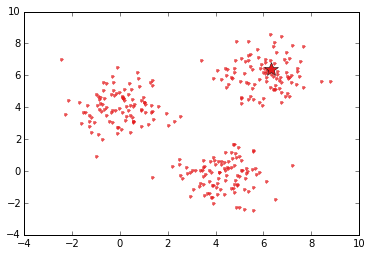

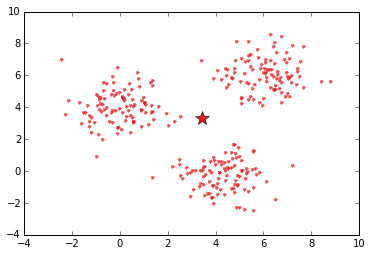


K = 1
At iteration 2 convergence condition is met
WSSSE = 1141.63781792
[[ 3.44374019  3.31458323]]



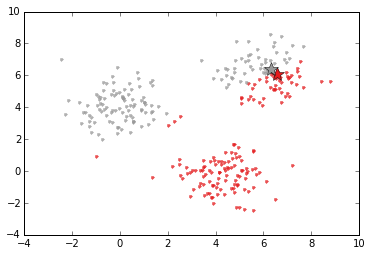

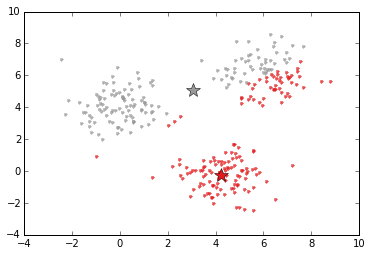


K = 2
At iteration 6 convergence condition is met
WSSSE = 792.342323355
[[ 4.23970169 -0.22644567]
 [ 3.03975973  5.11178886]]



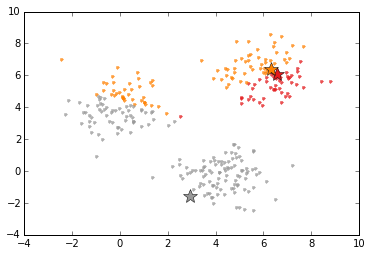

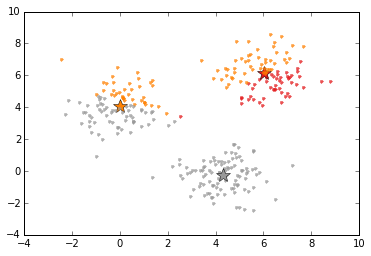


K = 3
At iteration 5 convergence condition is met
WSSSE = 375.366658223
[[ 6.04583746  6.11976758]
 [-0.00684447  4.06203763]
 [ 4.29222758 -0.23805551]]



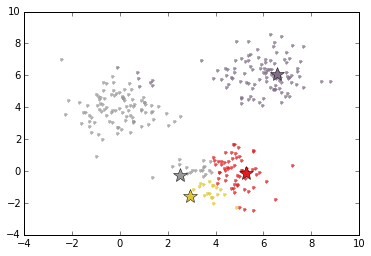

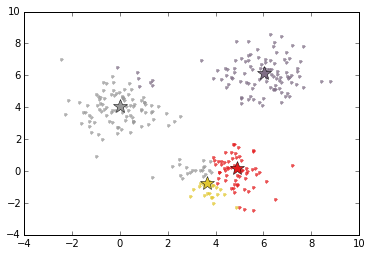


K = 4
At iteration 5 convergence condition is met
WSSSE = 349.305692152
[[ 4.90636085  0.21967344]
 [ 6.04583746  6.11976758]
 [ 3.62691654 -0.73392853]
 [-0.00684447  4.06203763]]



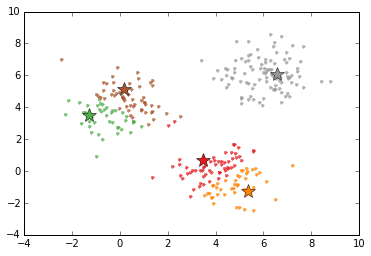

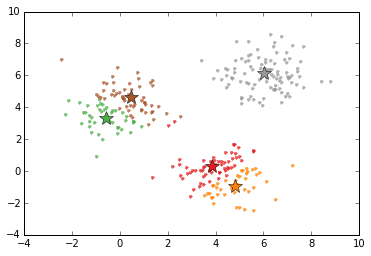


K = 5
At iteration 4 convergence condition is met
WSSSE = 324.944771032
[[ 3.86584852  0.32294834]
 [-0.5629421   3.32753233]
 [ 4.81335755 -0.92372688]
 [ 0.44814451  4.6629965 ]
 [ 6.04583746  6.11976758]]



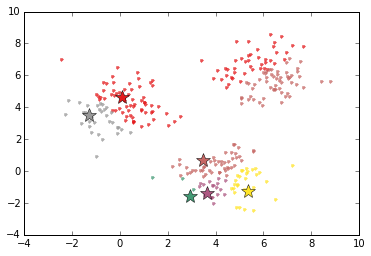

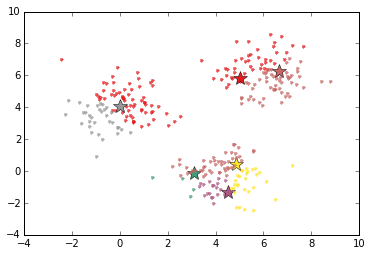


K = 6
At iteration 11 convergence condition is met
WSSSE = 305.314556517
[[ 5.02320594  5.8493116 ]
 [ 3.1001998  -0.13738988]
 [ 4.53940221 -1.30409134]
 [ 4.86826273  0.44248178]
 [ 6.67261161  6.28553093]
 [-0.00684447  4.06203763]]



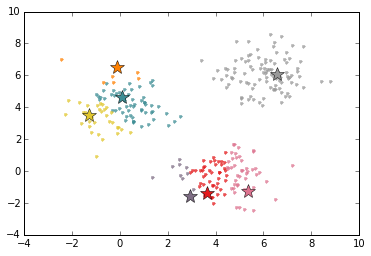

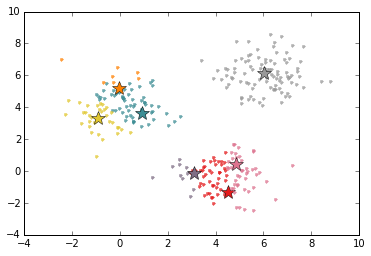


K = 7
At iteration 10 convergence condition is met
WSSSE = 283.858698555
[[ 4.53940221 -1.30409134]
 [ 0.91858861  3.66219258]
 [ 3.1001998  -0.13738988]
 [-0.05265657  5.19056701]
 [-0.91450886  3.34546982]
 [ 4.86826273  0.44248178]
 [ 6.04583746  6.11976758]]



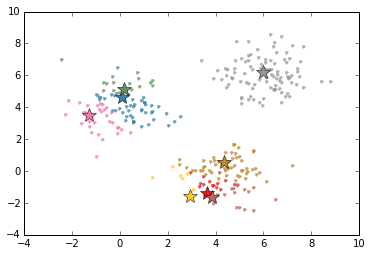

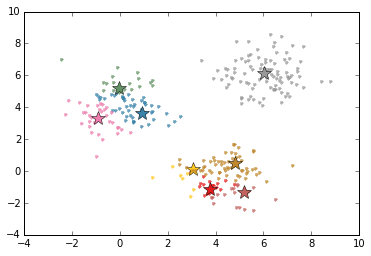


K = 8
At iteration 6 convergence condition is met
WSSSE = 274.643567137
[[ 3.77653286 -1.13843442]
 [ 0.91858861  3.66219258]
 [-0.05265657  5.19056701]
 [ 5.18131758 -1.29589225]
 [ 3.03868433  0.09889872]
 [ 4.82977557  0.48914311]
 [-0.91450886  3.34546982]
 [ 6.04583746  6.11976758]]



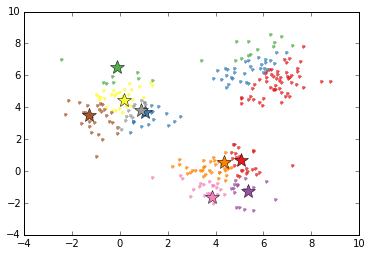

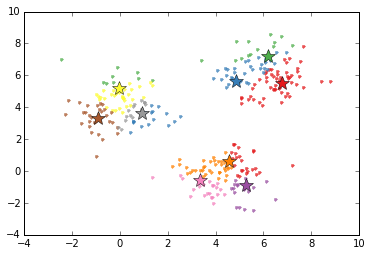


K = 9
At iteration 10 convergence condition is met
WSSSE = 240.963194115
[[ 6.76593748  5.54636806]
 [ 4.87030904  5.67268895]
 [ 6.17429979  7.22771079]
 [ 5.25602901 -0.87043988]
 [ 4.5566144   0.63676771]
 [-0.05265657  5.19056701]
 [-0.91450886  3.34546982]
 [ 3.34550148 -0.55482464]
 [ 0.91858861  3.66219258]]



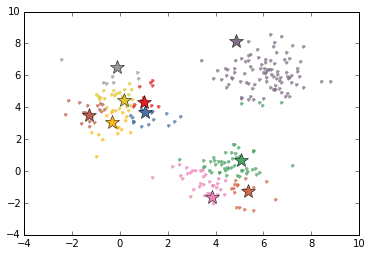

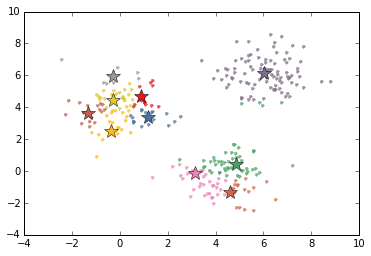


K = 10
At iteration 10 convergence condition is met
WSSSE = 266.824744161
[[ 0.86738919  4.6886763 ]
 [ 1.1633564   3.41091032]
 [ 4.83916795  0.46749586]
 [ 6.04583746  6.11976758]
 [ 4.60573918 -1.31052549]
 [-0.35847945  2.52002113]
 [-0.29494262  4.43975249]
 [-1.34438693  3.63007919]
 [ 3.13591174 -0.14730758]
 [-0.28845641  5.97145061]]



In [35]:
D = sc.textFile("./data.csv").cache()
WSSSE = []
Num_Iter = []
for k in range(1,11):    
    ## Initialization: choose the K centroids randomly from the dataset
    centroids = D.takeSample(False, k, 123456)
    centroids = np.array([[float(x) for x in y.split(',')] for y in centroids])
    centroids_id = [(x, centroids[x]) for x in range(centroids.shape[0])]
    ## Plot the original centroids
    plot_cluster2(D, centroids_id, k)
    ## Call to the function in previous cell
        ## It also plots the centroids (and clusters)
        ## and prints WSSSE and centroids when convergence condition is met
    [num_iter,wssse] = homegrown_Kmeans(D, k, centroids)
    ## Keep track of WSSE and number of iterations at convergence for each 
        ## value of K
    WSSSE.append(wssse)
    Num_Iter.append(num_iter)

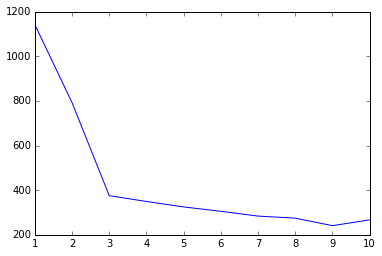

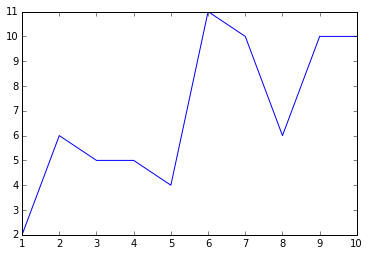

In [36]:
## WSSSE and Number of Iterations 'til convergence vs. K
pylab.plot(range(1,11),WSSSE)
pylab.show()
pylab.plot(range(1,11),Num_Iter)
pylab.show()

# HW10.6 (OPTIONAL)

## HW 10.6.1

**Using the following linear regression notebook:**

**https://www.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb?dl=0**

**Generate 2 sets of data with 100 data points using the data generation code provided and plot each in separate plots. Call one the training set and the other the testing set.**

**Using MLLib's LinearRegressionWithSGD train up a linear regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the linear regression model? Justify with plots and words.**

In [130]:
import numpy as np
import csv
def data_generate(fileName, w=[0,0], size=100):
    np.random.seed(0)
    x = np.random.uniform(-4, 4, size)
    noise = np.random.normal(0, 2, size)
    y = (x * w[0] + w[1] + noise)
    data = zip(y, x)
    with open(fileName,'wb') as f:
        writer = csv.writer(f)
        for row in data:
            writer.writerow(row)
    return True

In [131]:
w = [8,-2]
data_generate('training.csv', w, 100)
data_generate('testing.csv', w, 100)

True

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
def dataPlot(file, w):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            plt.plot(float(row[1]), float(row[0]),'o'+'r')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(file)
    x = [-4, 4]
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x,y, linewidth=2.0)
    plt.grid()
    plt.show()

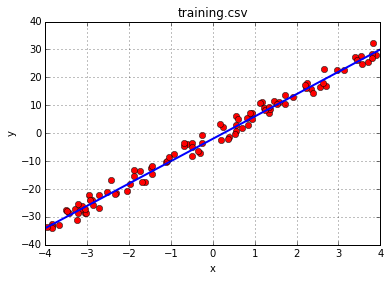

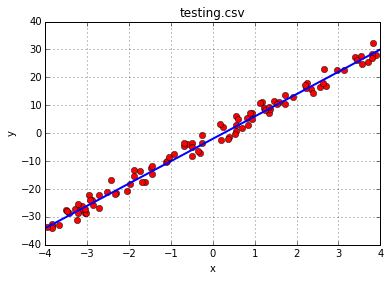

In [133]:
dataPlot('training.csv',w)
dataPlot('testing.csv',w)

In [255]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, \
    LinearRegressionModel

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(',')]
    return LabeledPoint(values[0], values[1:])

training = sc.textFile("training.csv")
parsedData1 = training.map(parsePoint)
training = sc.textFile("testing.csv")
parsedData2 = testing.map(parsePoint)

# Build the model
model = LinearRegressionWithSGD.train(parsedData1, intercept=True, 
                                      iterations=50)
print model
print '================'

# Evaluate the model on testing data
valuesAndPreds = parsedData2.map(lambda p: (p.label, model.predict(p.features)))
MSE = valuesAndPreds.map(lambda (v, p): (v - p)**2).\
    reduce(lambda x, y: x + y) / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))


(weights=[7.98393748404], intercept=-1.618744913188734)
Mean Squared Error = 3.96975506862


In [175]:
print model.weights[0]
print model.intercept

7.98393748404
-1.61874491319


In [256]:
def iterationsPlot_mllib(TrainingFile, TestingFile, truew, intermediate=True):
    def parsePoint(line):
        values = [float(x) for x in line.split(',')]
        return LabeledPoint(values[0], values[1:])
    
    x = [-4, 4]
    
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    training = sc.textFile(TrainingFile)
    parsedData1 = training.map(parsePoint)
    training = sc.textFile(TestingFile)
    parsedData2 = testing.map(parsePoint)
    
    data1 = sc.textFile(TrainingFile).\
        map(lambda line: [float(v) for v in line.split(',')]+[1.0]).\
        cache()
    data2 = sc.textFile(TestingFile).\
        map(lambda line: [float(v) for v in line.split(',')]+[1.0]).\
        cache()
          
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    print w
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data2.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).\
        reduce(lambda a, b: a + b)
    print "Mean Squared Error after 0 iterations: " + str(squared_error/n)
    
    if intermediate == True:
        model = LinearRegressionWithSGD.train(parsedData1, intercept=True, 
                                          iterations=5)
        w = [model.weights[0], model.intercept]
        print w
        y = [(i * w[0] + w[1]) for i in x]
        plt.plot(x, y, 'g--', label="After 5 Iterations", linewidth=2.0)
        squared_error = data2.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).\
            reduce(lambda a, b: a + b)
        print "Mean Squared Error after 5 iterations: " + str(squared_error/n)

        model = LinearRegressionWithSGD.train(parsedData1, intercept=True, 
                                          iterations=10)
        w = [model.weights[0], model.intercept]
        print w
        y = [(i * w[0] + w[1]) for i in x]
        plt.plot(x, y, 'm--', label="After 10 Iterations", linewidth=2.0)
        squared_error = data2.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).\
            reduce(lambda a, b: a + b)
        print "Mean Squared Error after 10 iterations: " + str(squared_error/n)

    model = LinearRegressionWithSGD.train(parsedData1, intercept=True, 
                                      iterations=15)
    w = [model.weights[0], model.intercept]
    print w
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 15 Iterations", linewidth=2.0)
    squared_error = data2.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).\
        reduce(lambda a, b: a + b)
    print "Mean Squared Error after 15 iterations: " + str(squared_error/n)

    model = LinearRegressionWithSGD.train(parsedData1, intercept=True, 
                                      iterations=20)
    w = [model.weights[0], model.intercept]
    print w
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'orange', label="After 20 Iterations", linewidth=2.0)
    squared_error = data2.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).\
        reduce(lambda a, b: a + b)
    print "Mean Squared Error after 20 iterations: " + str(squared_error/n)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

[-1.13057051  0.69620023]
Mean Squared Error after 0 iterations: 464.394955261
[503.99285925531717, -26.27812753741415]
Mean Squared Error after 5 iterations: 1326328.30024
[-298.44535587214739, 13.616204267077869]
Mean Squared Error after 10 iterations: 506216.356076
[16.768320436411887, -2.055464941127268]
Mean Squared Error after 15 iterations: 419.942124701
[7.9725757904051031, -1.6181780801746704]
Mean Squared Error after 20 iterations: 3.9704873112


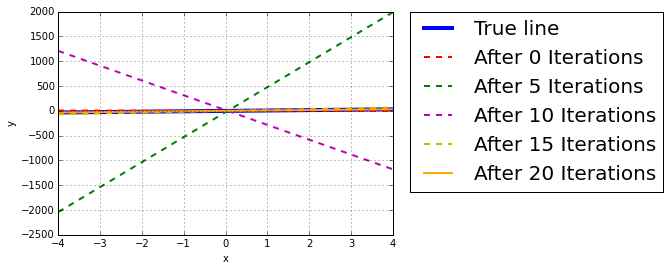

In [257]:
iterationsPlot_mllib('training.csv','testing.csv',w)

To distinguish between the first and final plots, let's omit the intermediate results (low number of iterations):

[-1.13057051  0.69620023]
Mean Squared Error after 0 iterations: 464.394955261
[16.768320436411887, -2.055464941127268]
Mean Squared Error after 15 iterations: 419.942124701
[7.9725757904051031, -1.6181780801746704]
Mean Squared Error after 20 iterations: 3.9704873112


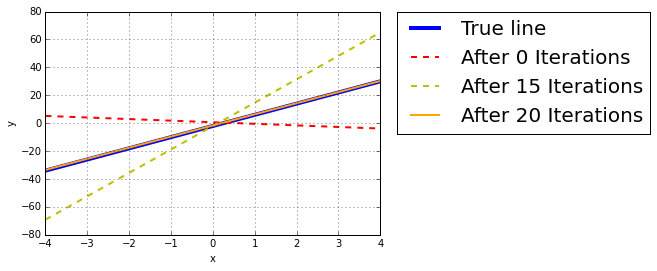

In [258]:
iterationsPlot_mllib('training.csv','testing.csv',w,False)

About 20 iterations are necessary to train the model with a low MSE (much lower than using random coefficientes, which is the case of "0 iterations"). I.e., to reach the global minimum of the cost function (the MSE in this case).

Of course, that would also depend on the `StepSize` parameter ($\eta$; haven't found the default value).

## END OF HW10

In [149]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, 
                       iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        ## Make available in memory as read-only to the executors (for mappers and reducers)
        wBroadcast = sc.broadcast(w)
        gradient = data.\
            map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * \
                np.array(d[1:])).\
            reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In [150]:
data = sc.textFile('training.csv').\
    map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
linearRegressionGD(data)

array([ 7.98418741, -1.61969498])

In [165]:
def iterationsPlot(fileName, truew):
    x = [-4, 4]
    
    w = truew
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'b', label="True line", linewidth=4.0)
    
    data = sc.textFile(fileName).map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache()
    n = data.count()
    
    np.random.seed(400)
    w = np.random.normal(0,1,2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'r--', label="After 0 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 0 iterations: " + str(squared_error/n)
    

    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'g--', label="After 2 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 2 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'm--', label="After 4 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 4 iterations: " + str(squared_error/n)
    
    w = linearRegressionGD(data, w, iterations=2)
    y = [(i * w[0] + w[1]) for i in x]
    plt.plot(x, y, 'y--', label="After 6 Iterations", linewidth=2.0)
    squared_error = data.map(lambda d: (d[0] - np.dot(w, d[1:]))**2).reduce(lambda a, b: a + b)
    print "Mean Squared Error after 6 iterations: " + str(squared_error/n)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, fontsize=20, borderaxespad=0.)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

Mean Squared Error after 0 iterations: 464.394955261
Mean Squared Error after 2 iterations: 27.0859380611
Mean Squared Error after 4 iterations: 6.40859048434
Mean Squared Error after 6 iterations: 4.9932567759


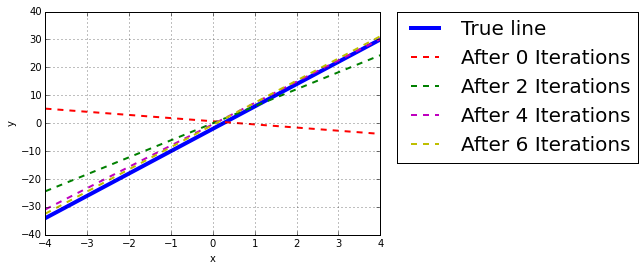

In [166]:
iterationsPlot('training.csv',w)